In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import torch
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

### Helper Functions

In [3]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()
G.cuda();

In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [5]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [6]:
def target_to_label(target):
    if not isinstance(target, np.ndarray):
        target = np.array(target.detach().cpu())
    return list(np.array(attributes_list)[np.argwhere(target.squeeze(1)!=0)].squeeze(1))

### Single Attribute: Category

In [7]:
attribute = 'category'
meta = pd.read_json(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json").T.rename_axis('sku').reset_index()
dummies = pd.get_dummies(meta[attribute])
attribute_order = list(dummies.columns)

#### Load CNF Model

In [8]:
model_save_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/StyleFlow/Outputs/category/StyleFlow_002500_15.pt"
os.chdir(f"{ROOT_PATH}/StyleFlow/")
from module.flow import cnf
prior = cnf(512, '512-512-512-512-512', 8, 1)
prior.load_state_dict(torch.load(model_save_path))
prior.eval();
os.chdir(current_wd)

Training T : 1.0
Number of trainable parameters of Point CNF: 1636353


#### Load Training Data

In [9]:
latent_path="/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/StyleFlow/Inputs/category/latents.npy"
attributes_path="/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/StyleFlow/Inputs/category/targets.npy"

In [10]:
latents = np.load(latent_path)
targets = np.load(attributes_path)

#### Test CNF Backward (Joint Reverse Encoding, JRE) and CNF Forward (Conditional Forward Editing, CFE) 

In [11]:
def run_example(att1, att2, magnitude=1):
    # Draw Random Sample
    sample = meta[meta.category == att1].sample(1)
    idx = sample.index.item()

    # Get the laten code and target
    latent_orig = torch.from_numpy(latents[idx]).type(torch.FloatTensor).cuda()
    target_orig = torch.from_numpy(targets[idx]).type(torch.FloatTensor).cuda()

    # Assign final target based on att2
    target_final = torch.zeros(8, 1, device='cuda')
    target_final[attribute_order.index(att2)] = 1

    # Set manipulation strength
    target_final = target_final * magnitude

    # Do the CNF Backward and Forward Operations
    zero_padding = torch.zeros(1, 16, 1).cuda()
    # Joint Reverse Encoding
    fws = prior(latent_orig, target_orig, zero_padding)
    # Conditional Forward Editing
    rev = prior(fws[0], target_final, zero_padding, True)

    # Plot images
    %matplotlib inline
    fig, ax = plt.subplots(1,2, figsize = (10,5))

    ax[0].imshow(generate_from_latent(latent_orig))
    ax[1].imshow(generate_from_latent(rev[0]))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title(f'Original: {att1}')
    ax[1].set_title(f'Edited: {att2}')
    plt.show()

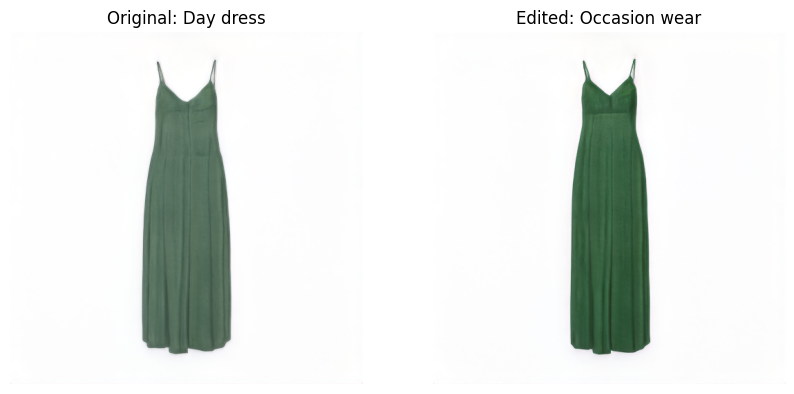

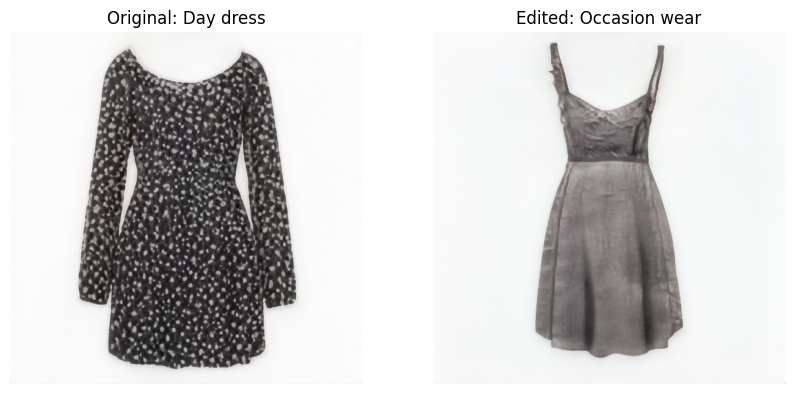

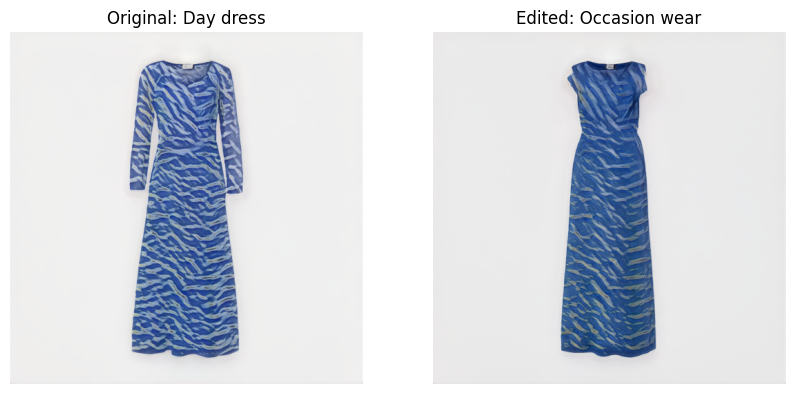

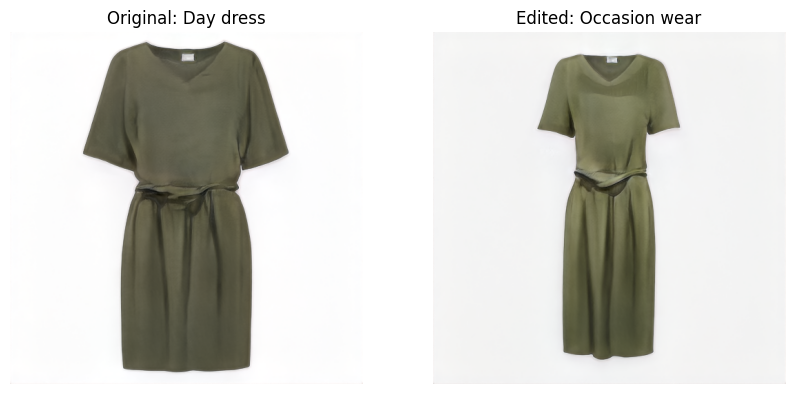

In [12]:
att1 = 'Day dress'
att2 = 'Occasion wear'

for i in range(10):
    run_example(att1, att2)

## Multi-Attribute Manipulations

In [ ]:
# Load attributes list
attributes_list = pickle.load(open('/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/StyleFlow/Inputs/multiple/attributes_list.pkl', 'rb'))

#### Load CNF Model

In [ ]:
model_save_path = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/StyleFlow/Outputs/multiple/StyleFlow_002500_24.pt"
os.chdir(f"{ROOT_PATH}/StyleFlow/")
from module.flow import cnf
prior = cnf(512, '512-512-512-512-512', len(attributes_list), 1)
prior.load_state_dict(torch.load(model_save_path))
prior.eval();
os.chdir(current_wd)

#### Load Training Data

In [ ]:
latent_path="/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/StyleFlow/Inputs/multiple/latents.npy"
attributes_path="/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/StyleFlow/Inputs/multiple/targets.npy"
latents = np.load(latent_path)
targets = np.load(attributes_path)

### Manipulations

In [ ]:
meta = pd.read_json(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json").T.rename_axis('sku').reset_index()
meta = meta[['sku', 'category', 'sleeve_length', 'color', 'pattern']]

#### Test CNF Backward (Joint Reverse Encoding, JRE) and CNF Forward (Conditional Forward Editing, CFE) 

In [ ]:
def run_example(cat, sleeve_length, color, pattern, target_cat, target_sleeve_length, target_color, target_pattern, magnitude=1):
    # Draw a sample that meets the starting conditions
    conditions = {
        'category': cat,
        'sleeve_length': sleeve_length,
        'color': color,
        'pattern': pattern
    }

    query_str = ' & '.join(f"{col} == {repr(val)}" for col, val in conditions.items() if val is not None)
    subset_df = meta.query(query_str)
    sample = subset_df.sample(1)
    idx = sample.index.item()
    
    # Get the laten code and target
    latent_orig = torch.from_numpy(latents[idx]).type(torch.FloatTensor).cuda()
    target_orig = torch.from_numpy(targets[idx]).type(torch.FloatTensor).cuda()

    # Create the Target Vector
    target_final = torch.zeros(len(attributes_list), 1, device='cuda')
    if target_cat is not None: 
        target_final[attributes_list.index(target_cat)] = 1
    else: 
        target_final[targets[idx][:8].argmax()] = 1
    if target_sleeve_length is not None: 
        target_final[attributes_list.index(target_sleeve_length)] = 1
    else: 
        current = targets[idx][8:18].argmax()
        current = attributes_list[8:18][current]
        target_final[attributes_list.index(current)] = 1
    if target_color is not None: 
        target_final[attributes_list.index(target_color)] = 1
    else: 
        current = targets[idx][19:33].argmax()
        current = attributes_list[19:33][current]
        target_final[attributes_list.index(current)] = 1
    if target_pattern is not None: 
        target_final[attributes_list.index(target_pattern)] = 1
    else:
        current = targets[idx][33:].argmax()
        current = attributes_list[33:][current]
        target_final[attributes_list.index(current)] = 1

    # Set manipulation strength
    target_final = target_final * magnitude

    # Do the CNF Backward and Forward Operations
    zero_padding = torch.zeros(1, 16, 1).cuda()
    # Joint Reverse Encoding
    fws = prior(latent_orig, target_orig, zero_padding)
    # Conditional Forward Editing
    rev = prior(fws[0], target_final, zero_padding, True)

    # Plot images
    %matplotlib inline
    fig, ax = plt.subplots(1,2, figsize = (15,7))

    ax[0].imshow(generate_from_latent(latent_orig))
    ax[1].imshow(generate_from_latent(rev[0]))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title(f'Original: {target_to_label(targets[idx])}')
    ax[1].set_title(f'Edited: {target_to_label(target_final)}')
    plt.show()

In [ ]:
cat = 'Occasion wear'
sleeve_length = 'Sleeveless'
color = None
pattern = 'Plain'

target_cat = 'Day dress'
target_sleeve_length = None
target_color = None
target_pattern = None

for i in range(10):
    run_example(cat, sleeve_length, color, pattern, target_cat, target_sleeve_length, target_color, target_pattern)